In [1]:
import os

# this allows for parallelization with pmap.
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(500)
import jax
import jax.numpy as jnp
import sys
sys.path.append('../src/')

from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
from functools import partial
from path_sampling import dfdt, div_f, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


## Example of Algorithm 1: with $b = -\nabla V$ for double well potenetial, and we condition on the end point

This is an instance of prior -> posterior transport.



In [2]:
potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    return -jax.grad(potential)(x)


s:  0.0
Train loss: 1104373.0
i:  0
s:  0.0
Train loss: 931799.625
i:  1
s:  0.1
Train loss: 1746636.5
i:  2
s:  0.2
Train loss: 667500.125
i:  3
s:  0.30000000000000004
Train loss: 29681.658203125
i:  4
s:  0.4
Train loss: 9332.4599609375
i:  5
s:  0.5
Train loss: 9486.291015625
i:  6
s:  0.6000000000000001
Train loss: 5966.052734375
i:  7
s:  0.7000000000000001
Train loss: 6513.02197265625
i:  8
s:  0.8
Train loss: 5834.90380859375
i:  9
s:  0.9
Train loss: 3992.542724609375
i:  10


Text(0, 0.5, 'Time')

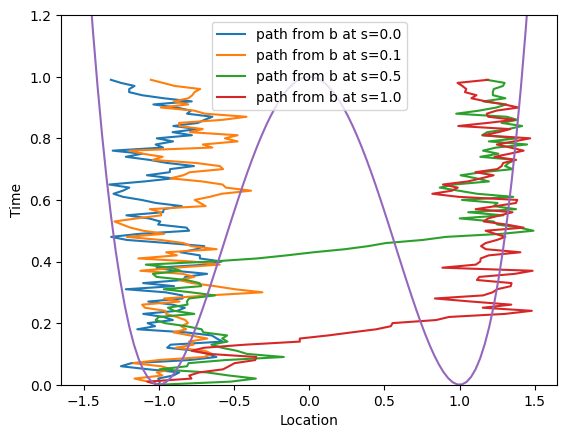

In [3]:
key = jax.random.key(0)
schedule = np.linspace(0,1,11)



# currently we're just doing an SDE on \mathbb{R}
ndims = 1

b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)  # b = -\nabla V
A_TH = 0


for i, s in enumerate(schedule):


    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)
    
    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential(v=5.0),
        b=b,
        J=lambda x,y: (1/2.0)*(1/0.1**2)*(x[-1,0]- 1)**2,   # condition on hitting x(T)=+1
        dbds=dbds,
        hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 250, 'batch_size' :500},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A_TH=A_TH,
        rho = lambda key: jnp.zeros((1,))-1.,   # initialize at -1
        refine=False,
        ndims=ndims,
        plotted_times=[0,1,5,10]
    )

potential = make_double_well_potential(v=1.0)
x = jnp.expand_dims(jnp.linspace(-1.5, 1.5, 100), 1)
y = potential(x)
# limit y axis to 5
plt.ylim(0, 1.2)
plt.plot(x, y)
plt.xlabel('Location')
plt.ylabel('Time')


## Rerun Algorithm 1 with SPDE turned on

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1. ]
s:  0.0
Train loss: 745696.25
i:  0
s:  0.0
Train loss: 960223.6875
i:  1
s:  0.1
Train loss: 470829.25
i:  2
s:  0.2
Train loss: 197807.3125
i:  3
s:  0.30000000000000004
Train loss: 87661.2734375
i:  4
s:  0.4
Train loss: 52645.77734375
i:  5
s:  0.5
Train loss: 26967.734375
i:  6
s:  0.6000000000000001
Train loss: 16578.060546875
i:  7
s:  0.7000000000000001
Train loss: 14143.6103515625
i:  8
s:  0.8
Train loss: 9383.970703125
i:  9
s:  0.9
Train loss: nan
i:  10
s:  1.0
Train loss: nan
i:  11


Text(0, 0.5, 'Time')

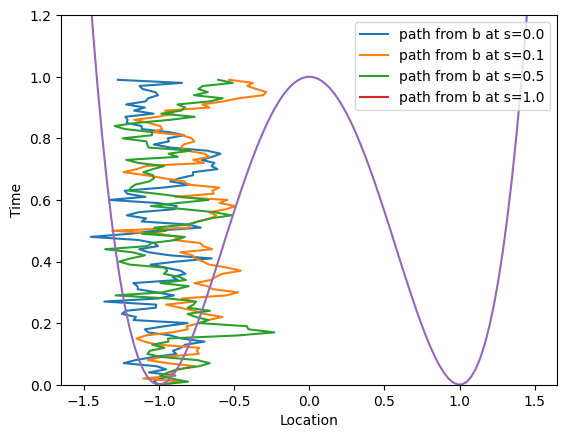

In [12]:


key = jax.random.key(10)
schedule = np.linspace(0,1,11)
print(schedule)



# currently we're just doing an SDE on \mathbb{R}
ndims = 1

b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)  # b = -\nabla V
A_TH = 0


for i, s in enumerate(schedule):


    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,20,10,1], key=nn_key)
    
    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential(v=5.0),
        b=b,
        J=lambda x,y: (1/2.0)*(1/0.1**2)*(x[-1,0]- 1)**2,   # condition on hitting x(T)=+1
        dbds=dbds,
        hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 250, 'batch_size' :500},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A_TH=A_TH,
        rho = lambda key: jnp.zeros((1,))-1.,   # initialize at -1
        refine=True,
        ndims=ndims,
        plotted_times=[0,1,5,10]
    )

potential = make_double_well_potential(v=1.0)
x = jnp.expand_dims(jnp.linspace(-1.5, 1.5, 100), 1)
y = potential(x)
# limit y axis to 5
plt.ylim(0, 1.2)
plt.plot(x, y)
plt.xlabel('Location')
plt.ylabel('Time')

    